In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

C:\Apps\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df=pd.read_csv('NeutralData.csv')
# df.head(22)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381750 entries, 0 to 381749
Columns: 129 entries, CH1 to Label
dtypes: float64(129)
memory usage: 375.7 MB


In [3]:
N_TIME_STEPS = 250
N_FEATURES = 128 #128
step = 10 # 20
segments = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    ch = []
    for j in range(0, N_FEATURES):
        ch.append(df.iloc[:, j].values[i: i + N_TIME_STEPS])
    segments.append(ch)

In [4]:
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    label = stats.mode(df['Label'][i: i + N_TIME_STEPS])[0][0]
    labels.append(label)
labelsl = np.asarray(pd.get_dummies(labels), dtype = np.float32)
#print(labelsl)

In [5]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labelsl, test_size=0.2, random_state=RANDOM_SEED)

In [6]:
print(np.array(segments).shape, reshaped_segments.shape, labelsl[0], len(X_train), len(X_test))

(38150, 128, 250) (38150, 250, 128) [1. 0.] 30520 7630


# Building the model

In [7]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [8]:
#https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [9]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [10]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [11]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred_Y, labels = Y)) + l2

In [12]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [13]:
N_EPOCHS = 50  # 50
BATCH_SIZE = 1024  # 1024

In [14]:
# https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

#     if i != 1 and i % 10 != 0:
#         continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.5467889904975891 loss: 6.618683815002441
epoch: 2 test accuracy: 0.5948885679244995 loss: 6.060047149658203
epoch: 3 test accuracy: 0.630013108253479 loss: 5.534384250640869
epoch: 4 test accuracy: 0.6591087579727173 loss: 5.072500705718994
epoch: 5 test accuracy: 0.6656618714332581 loss: 4.651984691619873
epoch: 6 test accuracy: 0.6567496657371521 loss: 4.291093349456787
epoch: 7 test accuracy: 0.6501966118812561 loss: 3.9673876762390137
epoch: 8 test accuracy: 0.6739187240600586 loss: 3.632908582687378
epoch: 9 test accuracy: 0.6601572632789612 loss: 3.384805679321289
epoch: 10 test accuracy: 0.6851900219917297 loss: 3.1047563552856445
epoch: 11 test accuracy: 0.6904324889183044 loss: 2.8796041011810303
epoch: 12 test accuracy: 0.6986894011497498 loss: 2.684786319732666
epoch: 13 test accuracy: 0.6815203428268433 loss: 2.50648832321167
epoch: 14 test accuracy: 0.7124508619308472 loss: 2.322136640548706
epoch: 15 test accuracy: 0.7104849219322205 loss: 2.1772

# Evaluation

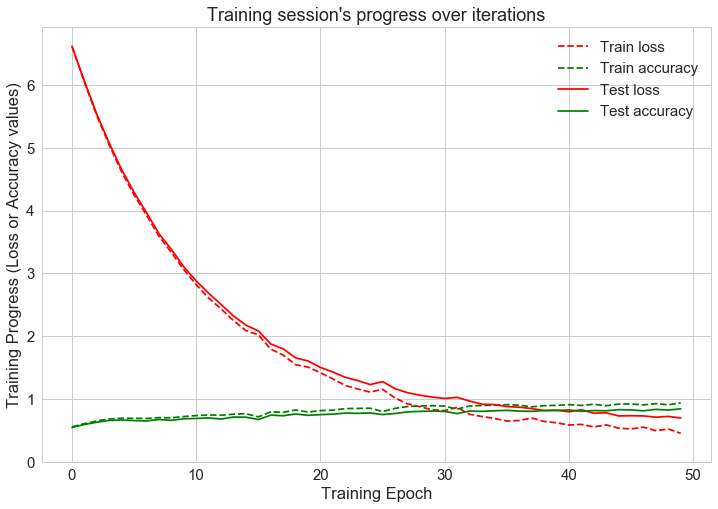

In [15]:
# https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

# Saving Model

In [16]:
import os

file_info = [N_HIDDEN_UNITS, BATCH_SIZE, N_EPOCHS]

dirname = os.path.dirname("nhid-{}_bat-{}_nepoc-{}/dumps/".format(*file_info))
if not os.path.exists(dirname):
    os.makedirs(dirname)
dirname = os.path.dirname("nhid-{}_bat-{}_nepoc-{}/logs/".format(*file_info))
if not os.path.exists(dirname):
    os.makedirs(dirname)

pickle.dump(predictions, open("nhid-{}_bat-{}_nepoc-{}/dumps/predictions.p".format(*file_info), "wb"))
pickle.dump(history, open("nhid-{}_bat-{}_nepoc-{}/dumps/history.p".format(*file_info), "wb"))
tf.train.write_graph(sess.graph, "nhid-{}_bat-{}_nepoc-{}/logs".format(*file_info), 'har.pbtxt')  
saver.save(sess, 'nhid-{}_bat-{}_nepoc-{}/logs/har.ckpt'.format(*file_info))

writer = tf.summary.FileWriter('nhid-{}_bat-{}_nepoc-{}/logs'.format(*file_info))
writer.add_graph(sess.graph)